This is a coding practice to train a simple MLP for MINST. Aug 7th
Motivation: I've written down numerious code snippets since I took ML/DL courses. But never had I ever executed a complete coding task from the first line to the last line of code.

The code is written in a explicit manner. I hope it particularly helps new learners.

In [1]:
pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 720.7 kB/s eta 0:00:00


# Set up environment

In [2]:
# libraries
import torch
import torch.nn as nn
import torchvision.datasets as datasets # Import datasets where you may load MNIST
import torch.optim as optim # Where you get optimization function
import torchvision.transforms as transforms # Where you get those data transformation techniques
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from einops import rearrange

# Loading the data

In [3]:
# Loading the training data

mnist_trainset = datasets.MNIST(root='./sample_data', train=True, download=True, transform=transforms.ToTensor())
train_dataloader = DataLoader(mnist_trainset, batch_size=64, shuffle=True)


# Loading the test data
mnist_testset = datasets.MNIST(root='./sample_data', train=False, download=True, transform=transforms.ToTensor())
test_dataloader = DataLoader(mnist_testset, batch_size=64, shuffle=False)

'''
Learning:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image to tensor
    # Add other necessary transforms here, e.g., normalization
])
This transforms image to tensor. (Notice that transforms.Compose can collect other transformations as well)
Otherwise it would raise the issue that nn.Module can not process "PIL image"
'''


100%|██████████| 9912422/9912422 [00:00<00:00, 90235642.29it/s]


Extracting ./sample_data/MNIST/raw/train-images-idx3-ubyte.gz to ./sample_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 76138085.37it/s]

Extracting ./sample_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./sample_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 23364419.03it/s]

Extracting ./sample_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./sample_data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 3433765.10it/s]

Extracting ./sample_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./sample_data/MNIST/raw



'\nLearning:\ntransform = transforms.Compose([\n    transforms.ToTensor(),  # Convert PIL image to tensor\n    # Add other necessary transforms here, e.g., normalization\n])\nThis transforms image to tensor. (Notice that transforms.Compose can collect other transformations as well)\nOtherwise it would raise the issue that nn.Module can not process "PIL image"\n'

# Pre-processing the data (If necessary)



*   It should include things such as transformations, which was included when data was loaded


*   Viewing data is also good to have.



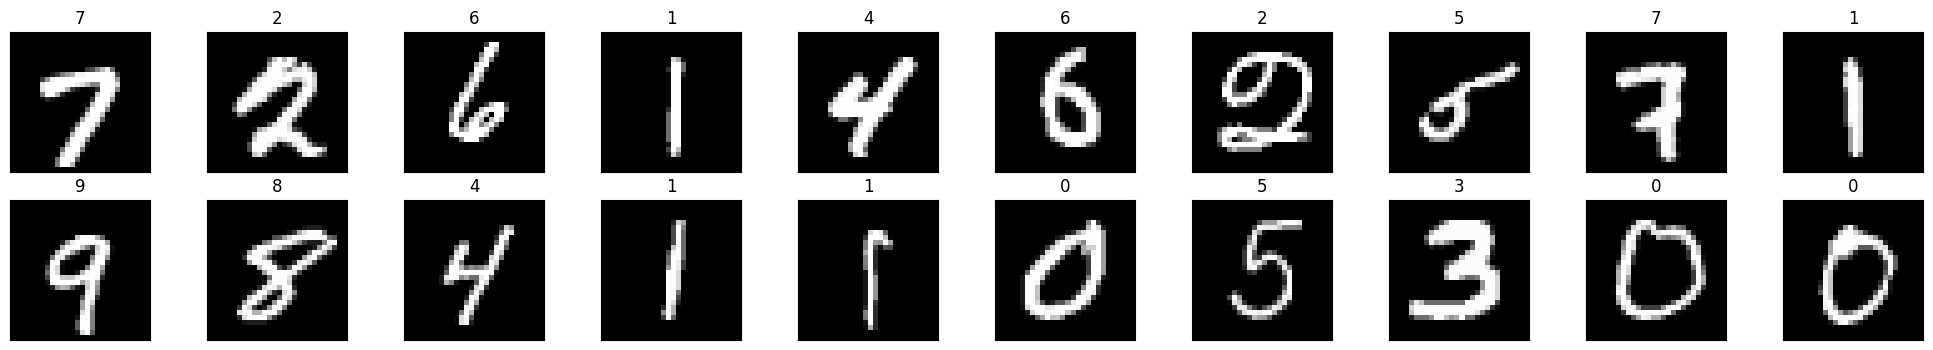

In [6]:
# Viewing data

# Get one batch of data (images and labels)
data_iter = iter(train_dataloader)
images, labels = next(data_iter)

# Plot the images
fig = plt.figure(figsize=(25,4))  # The size of the figure
for idx in range(20): # Show the first 20 images in the batch
  ax = fig.add_subplot(2,10,idx + 1, xticks=[], yticks=[])
  ax.imshow(images[idx].squeeze(), cmap='gray') # squeeze() is used to remove any unnecessary dimensions, e.g., (1, 28, 28) -> (28, 28)
  ax.set_title(str(labels[idx].item()))
plt.show()

# MLP Layer



Structuree:

*   Fully connected layer 1

*   Activation function (specific choice does not matter)

*   FC layer 2

Notice
*   Softmax not included here bc it is implictly included in the Adam optimizer








In [7]:
class MLP(nn.Module):  #
  def __init__(self, input_size, hidden_dim, output_size):
    super(MLP, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_dim)    # (in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
    self.G = nn.GELU()
    self.fc2 = nn.Linear(hidden_dim, output_size)
    # self.S = nn.Softmax2d() # Isn't SM needed? - Yes - it is implicitly included in the CrossEntropyLoss.
  def forward(self, x):
    x = self.fc1(x)
    x = self.G(x)
    prediction = self.fc2(x)
    return prediction


# When you want to execute the model
input_size = 784 # MNIST Image: 28*28=784
hidden_dim = 500 # A random but appropriate number for h_d
output_size = 10 # output size for mnist classfication task
model = MLP(input_size, hidden_dim, output_size)
print('model:', type(model))


model: <class '__main__.MLP'>


# Hyper-parameters

In [8]:
'''
Hyper-parameters to be defined:
- lr
- choice of optimizer
- choice of loss function

'''

# Choice of Loss function
criterion = nn.CrossEntropyLoss()  # The softmax function is contained in this CEL function.
# Choice of optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001) # '.parameters()' is a method of nnModule



# Backpropagation and training loop
You will define a class for backpropation where gradient is calculated

Structure
*   Iterate through every epoch, then every batch
*   Flatten your data: 'b c h w -> (b c)(h w)'
*   Call your model function (forward) to cal predictions (y)
*   Cost & weights 三部曲：cost, zero grad, gradients, weights
*   Graph: If you want to plot cost-epoch graph:
  losses.append(loss.item())  #.item(): from a single-value tensor to a python float


Notice:
*   I didn't use either class or function because we don't need to reuse this.
*   only use "enumerate" when you need to use the index for batch
*   Things per batch: cal cost, zero grad, cal gradients, update weights.




In [6]:
print(type(train_dataloader))

<class 'torch.utils.data.dataloader.DataLoader'>


In [7]:
'''
BP 这里我有点问题：
- 每一个batch计算一次cost吗？ yes
- 每一次计算cost都要更新gradient吗？ yes
- 更新gradient之后如何更新不同的weights & biases? optimizer.step()
- 循环算法在def里面吗？

'''

losses = [] # Difine a empty dictionary for loss. This is for plotting the graph later.
epoches = 10 # For a toy model, maybe running through the dataset 10 times is a good idea
# def backward(x): Let's see what would happen if we don't even define a function here
for epoch in range(epoches):
  for batch_idx, (data, label) in enumerate(train_dataloader):
    # print('dtype:', data.dtype, data.shape)
    data_flatten = rearrange(data,'b c h w -> (b c)(h w)')
    # print('data_flatten:', data_flatten.dtype)
    prediction = model(data_flatten)
    loss = criterion(prediction, label)
    optimizer.zero_grad() # We call zero_grad before each run because you want gradient to be updated for each mini training run (each batch). https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch
    loss.backward() # We call ".backward" to calculate gradients for each training run
    optimizer.step() # We update the model weights according to the gradients
    print(f'The {batch_idx} batch, training loss is {loss}')
  print(f'The {epoch} epoch, training loss is {loss}')

  # Yes we want a loss-epoch graph
  losses.append(loss.item())  #.item(): from a single-value tensor to a python float


Streaming output truncated to the last 5000 lines.
The 634 batch, training loss is 0.09162287414073944
The 635 batch, training loss is 0.18906784057617188
The 636 batch, training loss is 0.09615503251552582
The 637 batch, training loss is 0.04665713757276535
The 638 batch, training loss is 0.38649293780326843
The 639 batch, training loss is 0.23225833475589752
The 640 batch, training loss is 0.09243569523096085
The 641 batch, training loss is 0.16631346940994263
The 642 batch, training loss is 0.1441897600889206
The 643 batch, training loss is 0.23657187819480896
The 644 batch, training loss is 0.26735952496528625
The 645 batch, training loss is 0.13479001820087433
The 646 batch, training loss is 0.16520661115646362
The 647 batch, training loss is 0.08063704520463943
The 648 batch, training loss is 0.12280645221471786
The 649 batch, training loss is 0.16447018086910248
The 650 batch, training loss is 0.3549378514289856
The 651 batch, training loss is 0.1725669950246811
The 652 batch, t

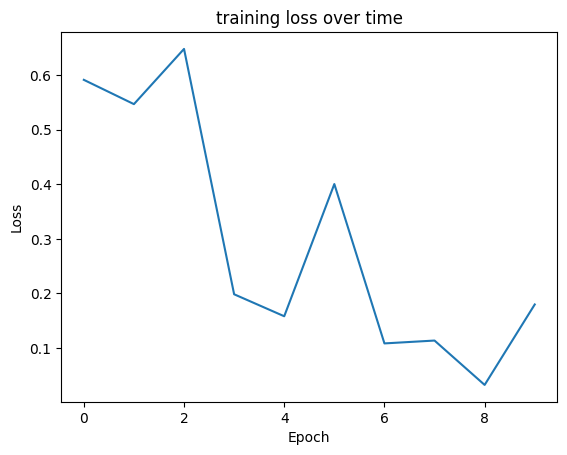

In [8]:
# Plot training loss over epoch
plt.plot(losses)
plt.title("training loss over time")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Training procedure

# Test

Notice:
*   You'd need to turn on eval mode first (model.eval()) and then turn off when you finish cal (model.train())
*   No gradient descent in the Testing
```
with torch.no_grad():
```
*   No "enumerate" bc you don't need batch_idx



In [9]:
from einops import reduce

In [15]:
def test(x, model):
  overall = 0 # Number of model making predictions
  accurate = 0 # Number of model making accurate predictions
  model.eval() # Set up the model in eval mode (where things such as dropout and normalization may behave differently.)
  with torch.no_grad():
    for data, label in x: # Notice that x is a dataloader but of tensor dtype
      data = rearrange(data,'b c h w -> (b c) (h w)') # x is flattened. [batch, all_else]
      logits = model(data)  # returning non-normalized probabilities
      # max_values = reduce(logits, "n c ->n", "max") # Notice that this einops method does not work here bc you are looking for the "labels", which are not returned (but only max values)
      _, prediction = logits.max(1) # You actually want the max value of 2nd dim of logits (batch_size, classes): max of each item (max out of all 10 classes).
      overall += prediction.size(0) # for each batch, you add in the number of "batch_size" predictions to denominator
      accurate += (prediction==label).sum() #  (prediction=label) -> produce boolean; .sum() turn boolean to 1 (yes) and 0 (no) and sum up to a scalar.
  model.train()
  accuracy = float(accurate/overall) # it seems originally they were tensor before float()
  print(f"Accuracy: {accuracy * 100:.2f}%")



In [16]:
# Implement the test function
test(test_dataloader, model)

Accuracy: 96.23%
